In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import datasets

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

# Feature Elimination Techniques

Often in datasets, we find that there exists columns that are wholly unrelated to the response we are trying to predict. Often this sort of inference can become very difficult to spot outside of certain unique cases like regression. In these situations, it becomes a non-trivial problem to identify which features need to be retained in the model. It can occur in the prediction of a continuous response that a certain column may only show its value in combination with another - for example, response is true if and only if both a and b are above 10. On their own they may show little to predictive value, but together they are highly effective.

We will go over a few ways to approach this problem.

## You must pass a tuned model, so we tune

In [2]:
Xs, y = datasets.make_classification(n_samples=1000, n_features=60, n_informative=30)

In [3]:
model = DecisionTreeClassifier()

grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
        'criterion':['entropy','gini']}

cross_val_folds = 3

gscv = GridSearchCV(model,grid,cv=cross_val_folds,verbose=True,
                    return_train_score=False)

gscv.fit(Xs,np.ravel(y))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=True)

In [4]:
scores = pd.DataFrame(gscv.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(5)

,param_criterion,param_max_depth,mean_test_score
0,gini,5,0.723
1,entropy,15,0.718
2,gini,7,0.718
3,entropy,11,0.718
4,entropy,12,0.716


## Loop through the Maximum Features and Get Cross Validated Accuracy

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Features')]

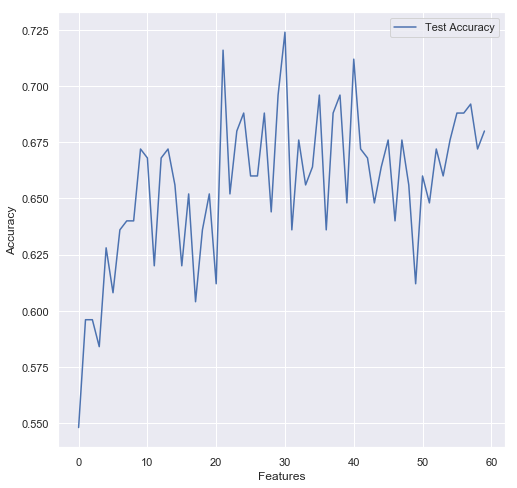

In [8]:
X_t, X_ho, y_t, y_ho = train_test_split(Xs, y, test_size=.25)
feature_inclusion = []
for i in range(len(Xs.T)):
    dtc = DecisionTreeClassifier(max_depth=5, criterion='gini', max_features=i+1)
    dtc.fit(X_t,y_t)
    feature_inclusion.append(dtc.score(X_ho,y_ho))
plt.figure(figsize=(8,8))
sns.lineplot(data=pd.DataFrame({'Test Accuracy':feature_inclusion})).set(
    xlabel='Features',ylabel='Accuracy')

In [9]:
features = []
means = []
for i in range(len(Xs.T)):
    dtc = DecisionTreeClassifier(max_depth=5, criterion='gini', max_features=i+1)
    cvs = cross_val_score(dtc,X=Xs,y=y,cv=5)
    features.append(cvs)
    means.append(cvs.mean())

## Plot the Accuracies over Predictors

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Features')]

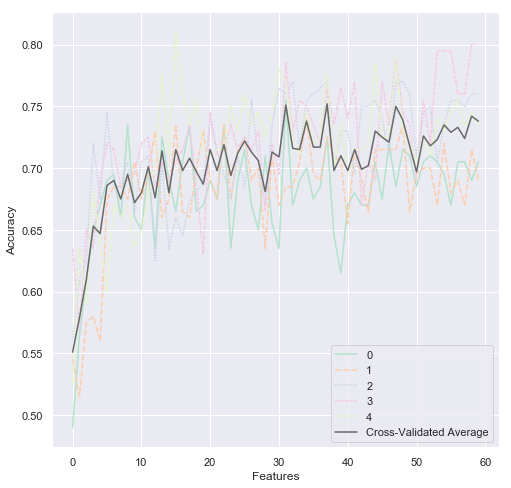

In [10]:
plt.figure(figsize=(8,8))
sns.lineplot(data=pd.DataFrame(features),palette='Pastel2').set(
    xlabel='Features',ylabel='Accuracy')
sns.lineplot(data=pd.DataFrame({'Cross-Validated Average':means}),palette='Greys_d').set(
    xlabel='Features',ylabel='Accuracy')

## But is there an easier way? More General?

Very similar to tuning the model, this comes down to experience and intuition. As you increase the number of predictors in a model, you must determine the optimal point to stop adding. In the case of the above, what looks like a reasonable place to stop? What was the explicitly defined number of informative features? Are these the same?

Looking through the code, you should note that this method of determining the optimal number of features lies soley in the ability to pass an argument choosing a maximum number. This is only available in a small subset of the models in SKLearn, the tree models.

We would like to expand this to be doable in most other models as well. In order to do this, we are going to need something equivalent to GridSearchCV except for Recursive Feature Elimination - this is called RFECV. You must pass a tuned model, as well as some information on what you would like to check and for models that have 'coef_' or 'feature_importance_' attributes, the algorithm can produce something very similar to the above.

## All the above code can be replecated with the below

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Features')]

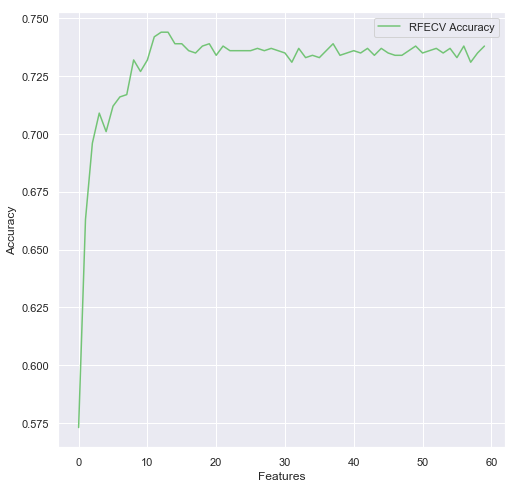

In [12]:
rfecv = RFECV(DecisionTreeClassifier(max_depth=5,criterion='gini'),cv=5)
rfecv.fit(Xs,y)
plt.figure(figsize=(8,8))
sns.lineplot(data=pd.DataFrame({'RFECV Accuracy':rfecv.grid_scores_ }),palette='Greens').set(
    xlabel='Features',ylabel='Accuracy')

This becomes very simple to create for many models! Let's see an example of this same thing, except using a support vector machine classifier.

## Now, for a Support Vector Classifier
## Tune

In [13]:
model = LinearSVC(max_iter=10000)

grid = {'C':[0.0001,0.001,0.01,0.1]}

cross_val_folds = 3

gscv = GridSearchCV(model,grid,cv=cross_val_folds,verbose=True,
                    return_train_score=False)

gscv.fit(Xs,np.ravel(y))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=True)

In [14]:
scores = pd.DataFrame(gscv.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(5)

,param_C,mean_test_score
0,0.1,0.841
1,0.001,0.838
2,0.01,0.838
3,0.0001,0.836


## Recursive Feature Elimination

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Features')]

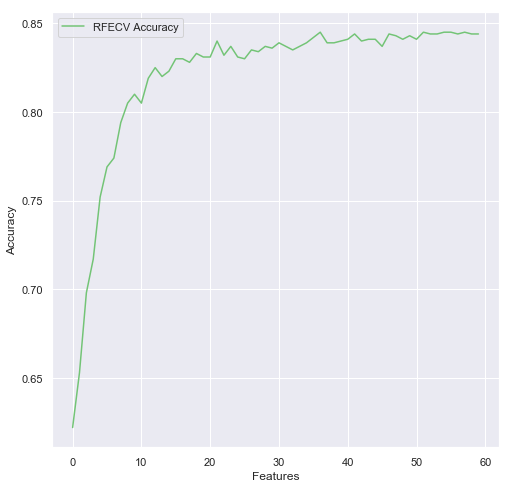

In [15]:
rfecv = RFECV(LinearSVC(C=0.01),cv=5)
rfecv.fit(Xs,y)
plt.figure(figsize=(8,8))
sns.lineplot(data=pd.DataFrame({'RFECV Accuracy':rfecv.grid_scores_ }),palette='Greens').set(
    xlabel='Features',ylabel='Accuracy')

## Regression Feature Elimination

This type of technique does not only work for classification activities. The process is nearly identical for regression, where the performance is simply evaluated over a metric such as the $R^2$.

In [16]:
Xs, y = datasets.make_regression(n_samples=1000, n_features=60, n_informative=30, noise=40)

## Classical Statistics - P-values on T-tests for Predictors

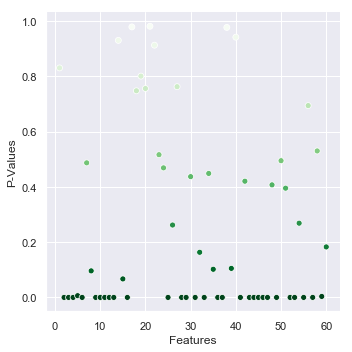

In [17]:
model = sm.OLS(y,Xs).fit()
pvalues = model.pvalues
sns.relplot(x='Features',y='P-Values',hue='P-Values', legend=False, data=pd.DataFrame(
    {'Features':np.arange(1,61),'P-Values':pvalues}),kind='scatter',palette='Greens_r')

## In SKLearn, for Ridge Regression
## Tune

In [18]:
model = Ridge()

grid = {'alpha':[0.0001,0.001,0.01,0.1,1,10]}

cross_val_folds = 3

gscv = GridSearchCV(model,grid,cv=cross_val_folds,verbose=True,
                    return_train_score=False)

gscv.fit(Xs,np.ravel(y))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=True)

In [19]:
scores = pd.DataFrame(gscv.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(5)

,param_alpha,mean_test_score
0,1,0.980621
1,0.1,0.980619
2,0.01,0.980619
3,0.001,0.980619
4,0.0001,0.980619


## Recursive Feature Elimination

[Text(0, 0.5, 'R2'), Text(0.5, 0, 'Features')]

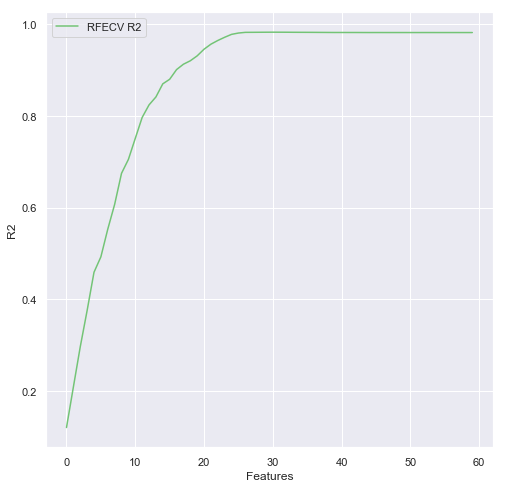

In [20]:
rfecv = RFECV(Ridge(alpha=1),cv=5,scoring='r2')
rfecv.fit(Xs,y)
plt.figure(figsize=(8,8))
sns.lineplot(data=pd.DataFrame({'RFECV R2':rfecv.grid_scores_ }),palette='Greens').set(
    xlabel='Features',ylabel='R2')

## Models Not Passable To RFECV

Unfortunately, you may come across models that are simply not passable into the RFECV. In these cases, should you find that these models which cannot be passed are far surpassing those that can, a technique would be to use some various checkmarks along the way where you use an alternative model to determine feature necessity and then use these column names as arguments in a filter. Let's do an analysis of this type using the Ridge Regression prototyping on the Lasso Regression (a Ridge regression with $l1$ regularization, i.e. $min(\frac{1}{n}\sum_{i=1}^{m}(y-\hat{y})^2+\alpha\times\sum_{i=1}^{n}(|w_i|))$, $n$ predictors, $m$ observations).

## Tune

In [21]:
model = Lasso()

grid = {'alpha':[0.0001,0.001,0.01,0.1,1,10]}

cross_val_folds = 3

gscv = GridSearchCV(model,grid,cv=cross_val_folds,verbose=True,
                    return_train_score=False)

gscv.fit(Xs,np.ravel(y))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=True)

In [22]:
scores = pd.DataFrame(gscv.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(5)

,param_alpha,mean_test_score
0,1,0.981113
1,0.1,0.980731
2,0.01,0.980631
3,0.001,0.980620
4,0.0001,0.980619


## Recursive Feature Elimination

[Text(0, 0.5, 'R2'), Text(0.5, 0, 'Features')]

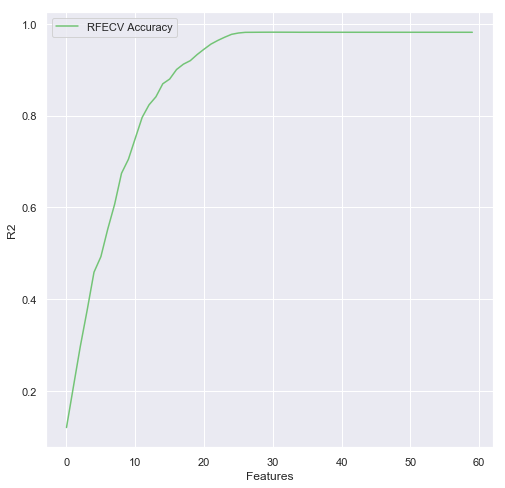

In [23]:
rfecv = RFECV(Lasso(alpha=1),cv=5,scoring='r2')
rfecv.fit(Xs,y)
plt.figure(figsize=(8,8))
sns.lineplot(data=pd.DataFrame({'RFECV Accuracy':rfecv.grid_scores_ }),palette='Greens').set(
    xlabel='Features',ylabel='R2')

## Add Predictors in the Same Order and Cross Validate

In [24]:
rfecv.ranking_

array([30,  1,  1,  1,  1,  1, 10,  1,  1,  1,  1,  1,  1, 14,  2,  1, 16,
       18, 20, 22, 24, 26, 28, 29,  1,  7, 12,  1,  1, 13,  1,  5,  1, 15,
        3,  1,  1, 27,  4, 25,  1, 23,  1,  1,  1,  1,  1, 11,  1, 17,  9,
        1,  1,  8,  1, 19,  1, 21,  1,  6])

In [25]:
test_values = np.arange(1,61)
columns = pd.DataFrame(Xs).columns
bests = []
model_accs = []
means = []

for i in rfecv.ranking_:
    bests.append(pd.DataFrame(Xs).columns[i-1])
for i in test_values:
    Xs_test = pd.DataFrame(Xs).loc[:,pd.DataFrame(bests).iloc[:i+1].values.flatten().tolist()]
    r = Ridge()
    cvs = cross_val_score(r,Xs_test,y,cv=5,scoring='r2')
    model_accs.append(cvs)
    means.append(cvs.mean())

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Features')]

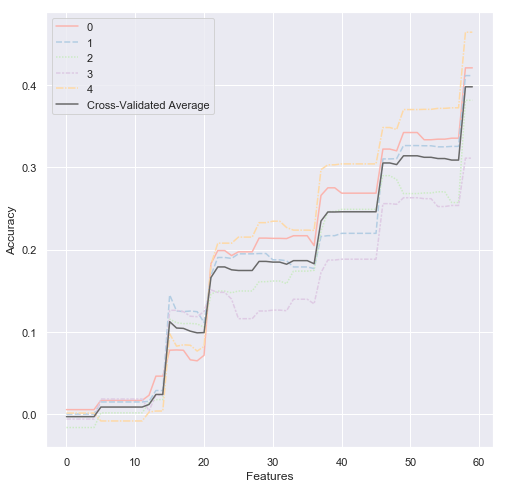

In [26]:
plt.figure(figsize=(8,8))
sns.lineplot(data=pd.DataFrame(model_accs),palette='Pastel1').set(
    xlabel='Features',ylabel='Accuracy')
sns.lineplot(data=pd.DataFrame({'Cross-Validated Average':means}),palette='Greys_d').set(
    xlabel='Features',ylabel='Accuracy')

The final note to make on this topic is that this did not work! We must evaluate each modeling technique individually as the importance of features may depend on how well a certain method works at evaluating the information within.

## Should you use this in your project? On what features?
Each group will confer and give a short response.